## Star Stacker

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import scipy
import os
import glob
import copy
from sklearn.neighbors import KDTree

In [8]:
notebookPath = os.path.abspath("StarStack.ipynb")
imgs = []
imsPath = os.path.join(os.path.dirname(notebookPath), "jpg/*")
for img in glob.glob(imsPath):
    nextImg = cv2.imread(img)
    nextImg = cv2.cvtColor(nextImg, cv2.COLOR_BGR2RGB)
    imgs.append(nextImg)
print(len(imgs), "images loaded")

2 images loaded


In [9]:
def getStarCoords(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #remove median light pollution
    img = cv2.subtract(img, np.median(img))

    #reduce effect of single pixels and non-prominent stars
    img = cv2.GaussianBlur(img, (0,0), 3)

    #create binary mask of star blobs
    starMask = np.zeros_like(img)
    imgStd = np.std(img)
    thresh = imgStd * 8 
    starBlobs = img > thresh
    starMask[starBlobs] = 1

    #get contours
    contours, _ = cv2.findContours(starMask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE)
    # print("number of stars:", len(contours))

    #get each star location from average position of blob perimeter
    starCoords = np.zeros((len(contours), 2), dtype=int)
    for c in range(len(contours)):
        starCoords[c, :] = np.mean(contours[c], axis=0)[0]
    return starCoords


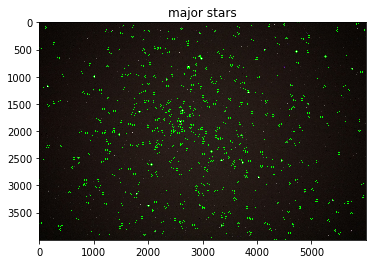

True

In [11]:
#Test and display the star coordinate finder

coords = getStarCoords(imgs[0])
starPlot = copy.deepcopy(imgs[0])
for point in coords:
    cv2.circle(starPlot, tuple(point), 20, (0, 255, 0), thickness=3)
plt.imshow(starPlot)
plt.title("major stars")
plt.show()
starPlot = cv2.cvtColor(starPlot, cv2.COLOR_BGR2RGB)
cv2.imwrite("major_stars.png", starPlot)

In [10]:
def showCorrespondances(pts1, pts2):
    correspondancePlot = copy.deepcopy(imgs[-1])
    correspondancePlot = cv2.cvtColor(correspondancePlot, cv2.COLOR_BGR2RGB)
    for i in range(pts1.shape[0]):
        cv2.line(correspondancePlot, tuple(pts1[i]), tuple(pts2[i]), (0, 255, 0), thickness=1)
    cv2.imwrite("correspondances.png", correspondancePlot)

def getRigidTransform(static, dynamic, numIter=8):
    '''
    Estimates a rigid body transform between two image frames. returns 3x3 homogenous matrix
    '''
    #find correspondances for each point
    tree = KDTree(static)
    _, idxs = tree.query(dynamic, k=1)
    nnList = static[idxs]
    nnList = nnList[:,0,:]
    showCorrespondances(nnList, dynamic)

    nnCentroid = np.mean(nnList, axis=0)
    dynamicCentroid = np.mean(dynamic, axis=0)
    nnm = nnList - nnCentroid
    dynamicm = dynamic - dynamicCentroid
    H = np.matmul(nnm.T, dynamicm)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T * U.T
    t = np.matmul(-R, nnCentroid) + dynamicCentroid
    rt = np.identity(3)

    rt[:2, :2] = R
    rt[:2, 2] = t
    return rt



In [6]:

points1 = getStarCoords(imgs[0])
points2 = getStarCoords(imgs[-1])
affineTransform = getRigidTransform(points1, points2)
print(affineTransform[:2])
out_size = (imgs[-1].shape[1], imgs[-1].shape[0])
im2_warp = cv2.warpAffine(imgs[-1], affineTransform[:2], out_size)
points2_warp = 
plt.imshow(im2_warp)
plt.title("transformed im2")
plt.show()
cv2.imwrite("affine_transformed_im2.jpg", im2_warp)

SyntaxError: invalid syntax (<ipython-input-6-b0277f62d84f>, line 7)